In [ ]:
#!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/dataset_ztOhYU1.zip"
!unzip thirdcombineddataset.zip
!unzip dataset.zip
#!unzip dataset.zip
#!rmd ataset_ztOhYU1.zip

Archive:  thirdcombineddataset.zip
   creating: combineddataset/
  inflating: combineddataset/train_labels.csv  
  inflating: __MACOSX/combineddataset/._train_labels.csv  
  inflating: combineddataset/.DS_Store  
  inflating: __MACOSX/combineddataset/._.DS_Store  
   creating: combineddataset/train_images/
  inflating: combineddataset/train_images/trainImage3720.jpg  
  inflating: combineddataset/train_images/fall-02-cam1-rgb-014.jpg  
  inflating: __MACOSX/combineddataset/train_images/._fall-02-cam1-rgb-014.jpg  
  inflating: combineddataset/train_images/fall-02-cam1-rgb-028.jpg  
  inflating: __MACOSX/combineddataset/train_images/._fall-02-cam1-rgb-028.jpg  
  inflating: combineddataset/train_images/trainImage2370.jpg  
  inflating: combineddataset/train_images/trainImage3250.jpg  
  inflating: combineddataset/train_images/trainImage2600.jpg  
  inflating: combineddataset/train_images/trainImage1490.jpg  
  inflating: combineddataset/train_images/trainImage820.jpg  
  inflating: comb

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
df_train = pd.read_csv('combineddataset/train_labels.csv', index_col='images')
test_df = pd.read_csv('dataset/test_labels.csv', index_col='images')
df_train

,labels
images,
trainImage10.jpg,0
trainImage20.jpg,0
trainImage30.jpg,1
trainImage40.jpg,1
trainImage50.jpg,1
...,...
fall-11-cam1-rgb-126.jpg,1
fall-11-cam1-rgb-127.jpg,1
fall-11-cam1-rgb-128.jpg,1


In [ ]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'combineddataset'
test_folder = 'dataset'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (96,96))
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])

for folder in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder)
    if folder == 'test_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)

Shape of stacked train images: (776, 96, 96, 3)
Shape of train labels: (776,)
Shape of stacked test images: (12, 96, 96, 3)


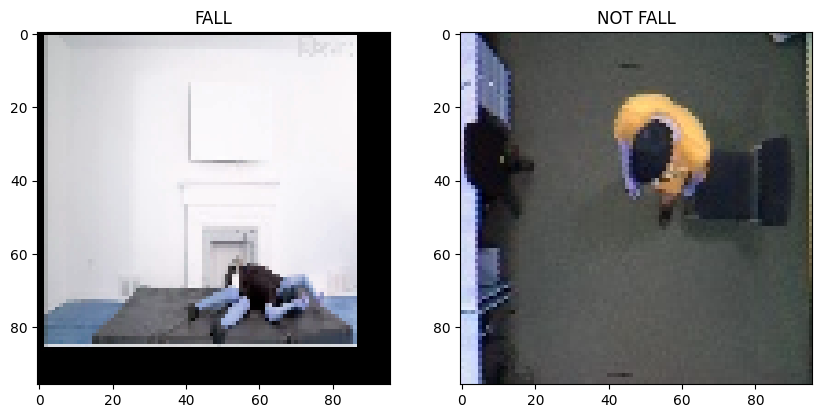

In [ ]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[3])
axes[0][1].set_title(get_label(train_labels[3]));

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

In [ ]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.regularizers import l2

# fallnet architecture
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='inputs')

conv1 = conv2d(16, name='convoluton_1')(model_input)
act1 = ReLU(name='activation_1')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(act1)

conv2 = conv2d(16, name='convolution_2')(pool1)
act2 = ReLU(name='activation_2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(act2)

conv3 = conv2d(32, name='convolution_3')(pool2)
act3 = ReLU(name='activation_3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(act3)

conv4 = conv2d(32, name='convolution_4')(pool3)
act4 = ReLU(name='activation_4')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(act4)

conv5 = conv2d(64, name='convolition_5')(pool4)
act5 = ReLU(name='activation_5')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(act5)

conv6 = conv2d(64, name='convolution_6')(pool5)
act6 = ReLU(name='activation_6')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(act6)

flat = Flatten(name='flatten')(pool6)
dense1 = Dense(32, name='dense1')(flat)
output = Dense(1, activation='sigmoid', name='output')(dense1)

model = Model(inputs=[model_input], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 96, 96, 3)]       0         
                                                                 
 convoluton_1 (Conv2D)       (None, 96, 96, 16)        448       
                                                                 
 activation_1 (ReLU)         (None, 96, 96, 16)        0         
                                                                 
 pooling_1 (MaxPooling2D)    (None, 48, 48, 16)        0         
                                                                 
 convolution_2 (Conv2D)      (None, 48, 48, 16)        2320      
                                                                 
 activation_2 (ReLU)         (None, 48, 48, 16)        0         
                                                                 
 pooling_2 (MaxPooling2D)    (None, 24, 24, 16)        0     

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train, epochs = 10, validation_data = (X_val, y_val))


Epoch 1/10
20/20 [==============================] - 8s 62ms/step - loss: 2.0299 - accuracy: 0.6661 - val_loss: 0.4069 - val_accuracy: 0.8141
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.2669 - accuracy: 0.9000 - val_loss: 0.2678 - val_accuracy: 0.8910
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.2124 - accuracy: 0.9177 - val_loss: 0.2911 - val_accuracy: 0.8718
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.1543 - accuracy: 0.9371 - val_loss: 0.2544 - val_accuracy: 0.8974
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.1777 - accuracy: 0.9210 - val_loss: 0.2790 - val_accuracy: 0.8974
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.1595 - accuracy: 0.9419 - val_loss: 0.2537 - val_accuracy: 0.8974
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.1147 - accuracy: 0.9581 - val_loss: 0.2673 - val_accuracy: 0.8782
Epoch 8/10
20/20 [=

In [ ]:
model.save('combinedmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


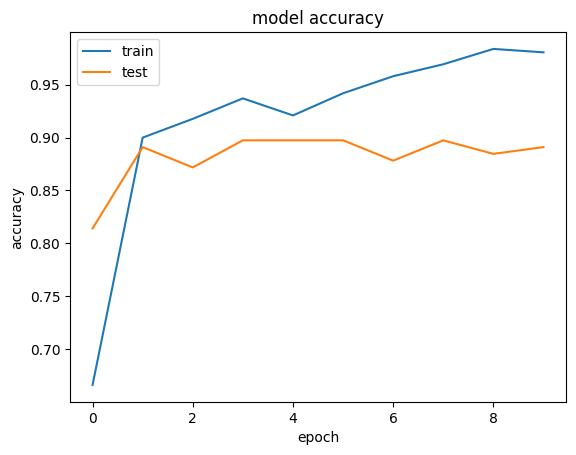

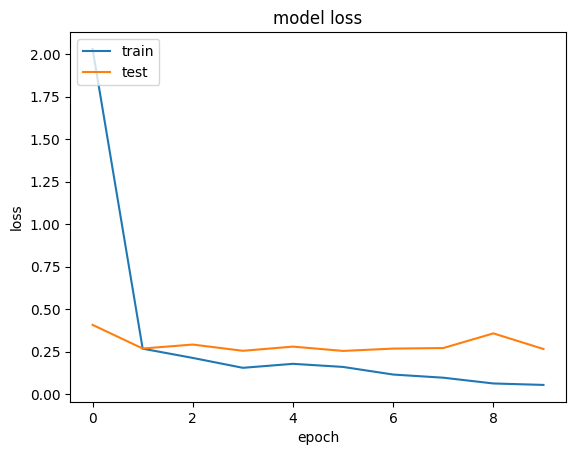

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

1/1 [==============================] - 0s 333ms/step


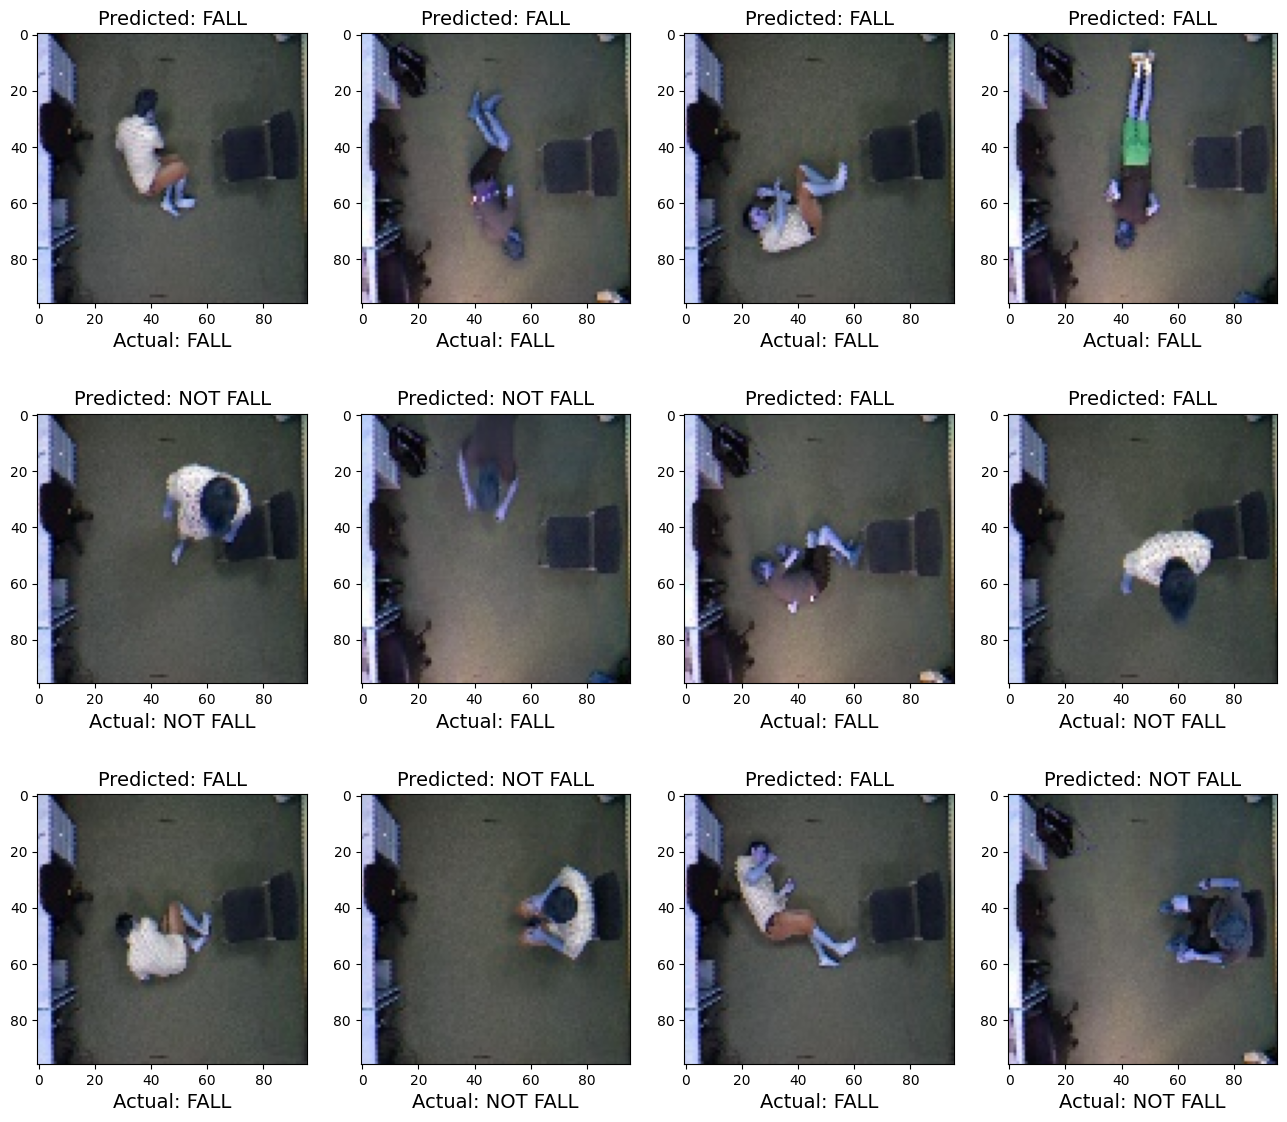

In [ ]:
# visualizing our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=14)
        c += 1
